# Pose estimation

In [108]:
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("../lab1")
from hourglass import HourglassNetwork

### Load image and keypoints

In [109]:
PATH = "../YCB-Video_data"
IMG_PATH = f"{PATH}/data/0010/000001-color.png"
KEYPOINTS_2D_PATH = f"{PATH}/keypoints/0010_gt_keypoints2d.npy"
KEYPOINTS_3D_PATH = f"{PATH}/models/035_power_drill/additional/picking_list.txt"
CAMERA_MATRIX_PATH = f"{PATH}/cameras/camera_matrix.npy"

img = cv2.imread(IMG_PATH)
DIM = img.shape
# keypoints_2d = np.load(KEYPOINTS_2D_PATH)[0].astype(np.float32)
keypoints_3d = np.genfromtxt(KEYPOINTS_3D_PATH, delimiter=',').astype(np.float32)
camera_matrix = np.load(CAMERA_MATRIX_PATH)

### Calculate 2D keypoints

In [110]:
MODEL_PATH = "../lab1/data/model"
num_keypoints = 9
net = HourglassNetwork(num_keypoints, 1, 128, DIM[:2], DIM[:2])
net.load(MODEL_PATH)


In [111]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_gray.shape = (1, DIM[0], DIM[1], 1)
heatmaps = net.predict(img_gray)
heatmaps.shape = (DIM[0]//4, DIM[1]//4, num_keypoints)

In [112]:
find_max = [heatmaps[:, :, i] == heatmaps[:, :, i].max() for i in range(num_keypoints)]
keypoints_2d = np.argwhere(find_max)            # Extract keypoints
keypoints_2d = keypoints_2d[:, [2, 1]]          # Reorder dimensions
keypoints_2d = keypoints_2d * 4                 # Scale to DIM
keypoints_2d = keypoints_2d.astype(np.float32)  # Convert to float

### Calculate the transformation vectors

In [113]:
dist_matrix = np.zeros((4, 1))
success, rot_vec, trans_vec = cv2.solvePnP(keypoints_3d, keypoints_2d, camera_matrix, dist_matrix)

### Projectile the pose line end point 

In [114]:
end_point_3d = np.array([0, 0, 1000], dtype=np.float32)
end_point_2d, _ = cv2.projectPoints(end_point_3d, rot_vec, trans_vec, camera_matrix, dist_matrix)

### Show estimated pose

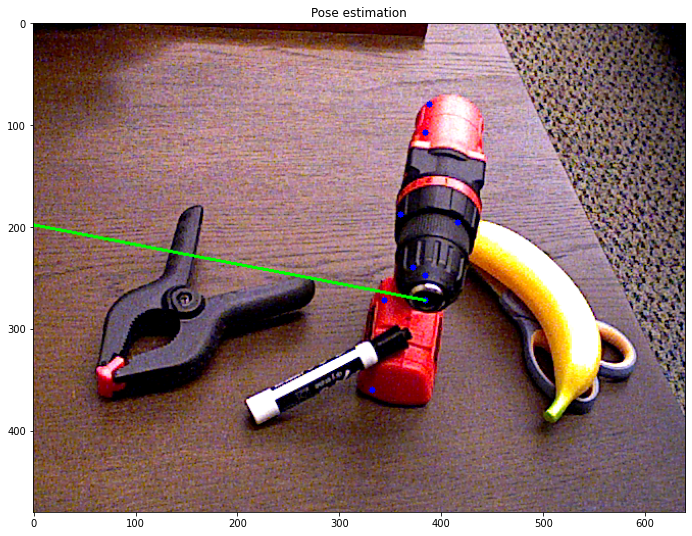

In [115]:
# Add keypoints to image
for p in keypoints_2d:
    cv2.circle(img, p.astype(np.int16), 3, (255, 0, 0), -1)
 
# Add pose line to image
p1 = keypoints_2d[0].astype(np.int16)
p2 = end_point_2d[0, 0].astype(np.int16)
cv2.line(img, p1, p2, (0, 255, 0), 2)
 
# Display image
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(16, 9))
plt.imshow(img)
plt.title("Pose estimation")
plt.show()